In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, TimeDistributed, Flatten, RepeatVector
from keras.layers import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

Using TensorFlow backend.
/home/volkovskyi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/volkovskyi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/volkovskyi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/volkovskyi/.local/lib/python3.6/site-packages/t

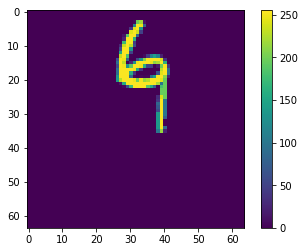

(9900, 10, 64, 64, 1)
(9900, 10, 64, 64, 1)


In [2]:
data = np.load("mnist_test_seq.npy")
data = np.swapaxes(data, 0, 1)

data_test_input = data[100:10000, :10, :, :]
data_test_output = data[100:10000, 10:20, :, :]

data_actual_test_input = data[0:100, :10, :, :]
data_actual_test_output = data[0:100, 10:20, :, :]

plt.imshow(data_test_input[4][0])
plt.colorbar()
plt.show()

#Scaling values between -1 and 1
data_test_input = (data_test_input) / 255.0
data_test_output = (data_test_output) / 255.0
data_actual_test_input = (data_actual_test_input) / 255.0
data_actual_test_output = (data_actual_test_output) / 255.0

#Adding Channels of dimension 1 IMPORTANT if using CNNs
train_in = np.expand_dims(data_test_input, axis=4)
train_out = np.expand_dims(data_test_output, axis=4)
test_in = np.expand_dims(data_actual_test_input, axis=4)
test_out = np.expand_dims(data_actual_test_output, axis=4)

print(train_in.shape)
print(train_out.shape)

# output_frames.shape
# output_frames = np.squeeze(output_frames, axis=1)
# test_output_frames = np.squeeze(test_output_frames, axis=1)
# plt.plot(test_output_frames[0])
# plt.show()

# output_frames.shape
# plt.imshow(np.squeeze(test_output_frames[1], axis=2))
# plt.show()

In [3]:
!ls

ConvLSTM.ipynb	  mnist_test_seq.npy  multiframeconvlstm_epoch10.h5
MFConvLSTM.ipynb  model3_epoch100.h5  TestModelOutputs.ipynb


In [6]:
#Define filters
filters = 20

model3 = Sequential()
model3.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=24, kernel_size=(3, 3),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', activation='elu'))
model3.add(BatchNormalization())

out_size = model3.layers[-1].output_shape
num_repeat = 10

model3.add(Flatten())
model3.add(RepeatVector(num_repeat))
model3.add(Reshape(tuple([num_repeat]) + out_size[1:]))

model3.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=24, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', activation='elu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', activation = 'sigmoid', return_sequences=True))


#Have model return one image with one channel/filter
#Output shape = (batch_size, 1, 64, 64, 1)
# model3.add(BatchNormalization())

# model3.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))
model3.compile(loss='mse', optimizer='adam')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_17 (ConvLSTM2D) (None, 10, 64, 64, 16)    9856      
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 64, 64, 16)    64        
_________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D) (None, 10, 64, 64, 24)    34656     
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 64, 64, 24)    96        
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 10, 64, 64, 32)    64640     
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 64, 64, 32)    128       
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, 64, 64, 16)       

In [4]:
model3 = keras.models.load_model('multiframeconvlstm_epoch10.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [6]:
print(train_out.shape)

(9900, 10, 64, 64, 1)


Epoch: 1
Epoch 1/1
9900/9900 [==============================] - 466s 47ms/step - loss: 0.0424


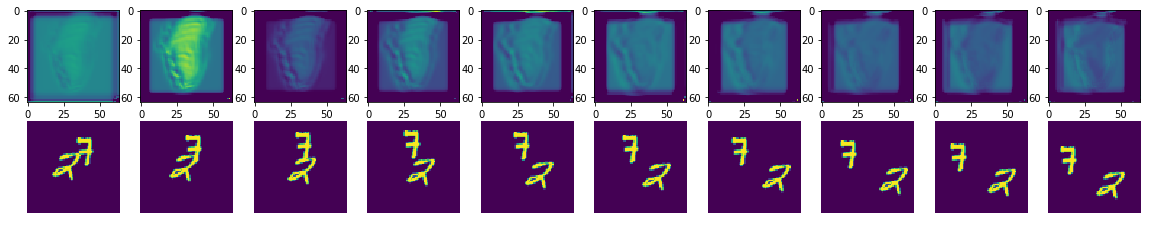

-----------------------------------
Epoch: 2
Epoch 1/1
9900/9900 [==============================] - 457s 46ms/step - loss: 0.0380


<Figure size 432x288 with 0 Axes>

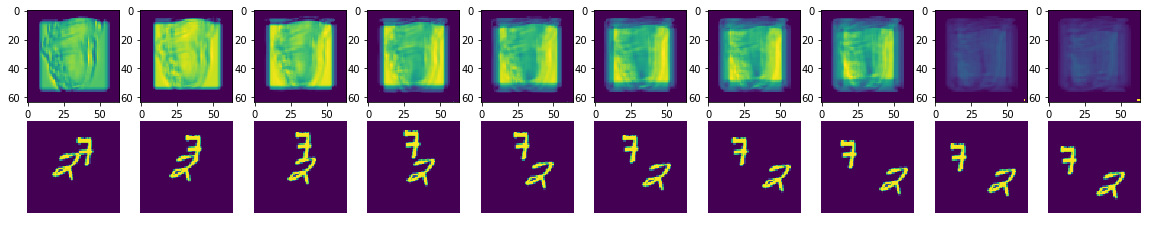

-----------------------------------
Epoch: 3
Epoch 1/1
9900/9900 [==============================] - 458s 46ms/step - loss: 0.0378


<Figure size 432x288 with 0 Axes>

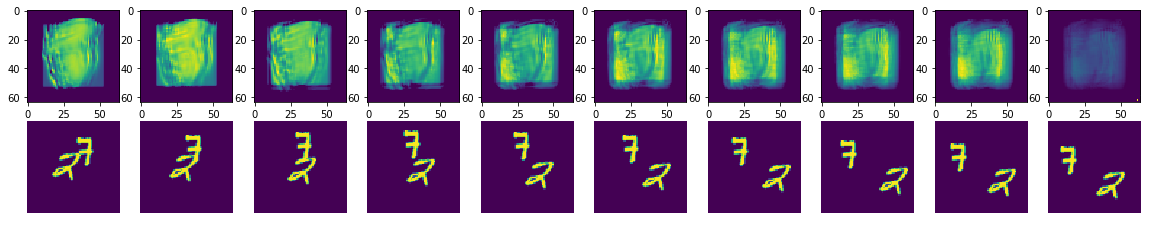

-----------------------------------
Epoch: 4
Epoch 1/1
9900/9900 [==============================] - 458s 46ms/step - loss: 0.0378


<Figure size 432x288 with 0 Axes>

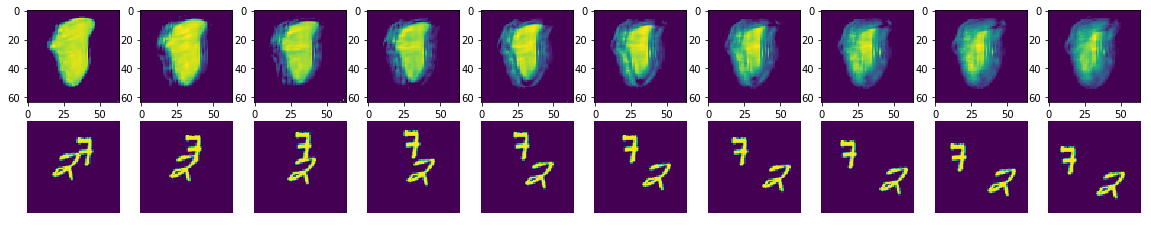

-----------------------------------
Epoch: 5
Epoch 1/1
9900/9900 [==============================] - 458s 46ms/step - loss: 0.0376


<Figure size 432x288 with 0 Axes>

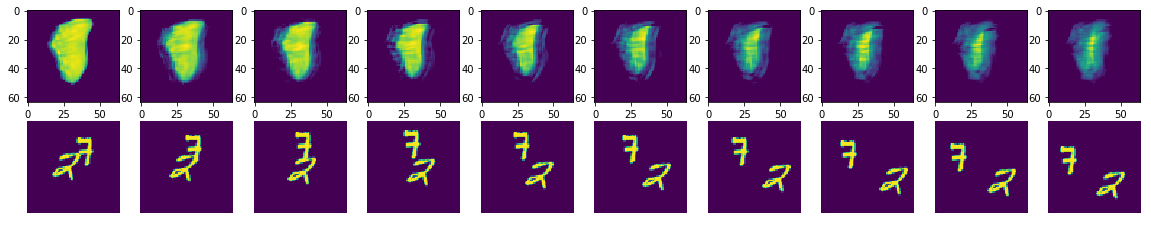

-----------------------------------
Epoch: 6
Epoch 1/1
9900/9900 [==============================] - 458s 46ms/step - loss: 0.0375


<Figure size 432x288 with 0 Axes>

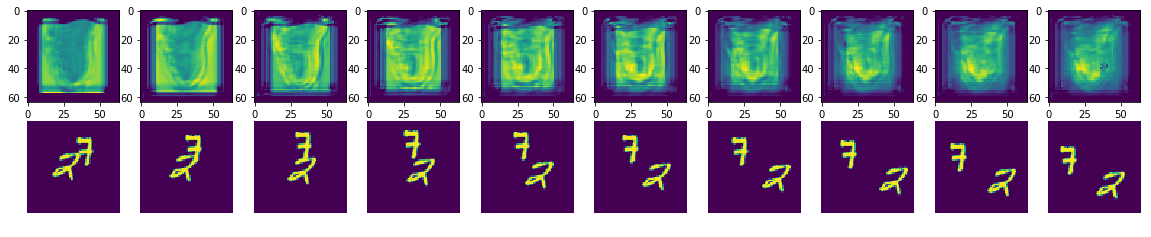

-----------------------------------
Epoch: 7
Epoch 1/1
9900/9900 [==============================] - 459s 46ms/step - loss: 0.0420


<Figure size 432x288 with 0 Axes>

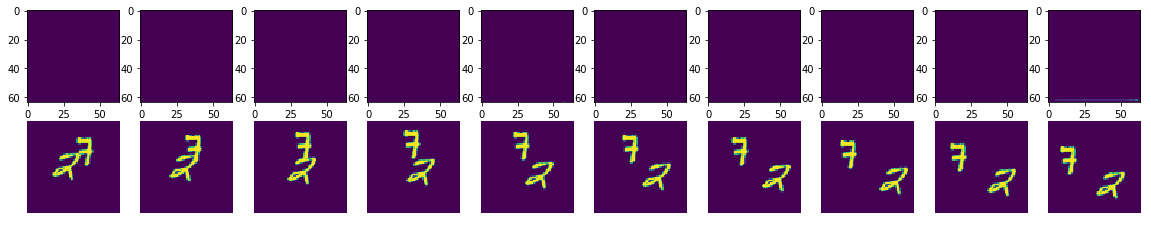

-----------------------------------
Epoch: 8
Epoch 1/1
9250/9900 [===========================>..] - ETA: 30s - loss: 0.0425

In [ ]:
for epoch in range(1,100):
    print("Epoch:",epoch)
    model3.fit(train_in, train_out, batch_size=10, epochs=1)
    
    inputs = test_in[:1, :10]
    ground_truth = test_out[:1, :10]
    predictions = model3.predict(inputs)
    predictions = predictions.reshape(10, 64, 64)
    ground_truth = ground_truth.reshape(10, 64, 64)
    plt.figure(figsize=(20, 20))
    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(predictions[i], interpolation='nearest')
        plt.subplot(10, 10, 10+i+1)
        plt.imshow(ground_truth[i], interpolation='nearest')
        plt.axis('off')
    plt.show()
    plt.tight_layout()
    
    if epoch % 4 == 0:
        model3.save('multiframeconvlstm_epoch'+str(epoch)+'.h5')
    print('-----------------------------------')